In [1]:
!python --version

Python 3.11.11


## Import Library

In [2]:
!pip install -U xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.9 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## Import Dataset

In [4]:
df = pd.read_csv('/kaggle/input/preprocessed-fake-reviews-dataset/preprocessed-fake-reviews-dataset.csv')

In [5]:
df.head()

,category,rating,label,text_,cleaned_text
0,Home_and_Kitchen_5,5.0,1,"Love this! Well made, sturdy, and very comfor...",Love this Well made sturdy and very comfortab...
1,Home_and_Kitchen_5,5.0,1,"love it, a great upgrade from the original. I...",love it a great upgrade from the original Ive...
2,Home_and_Kitchen_5,5.0,1,This pillow saved my back. I love the look and...,This pillow saved my back I love the look and ...
3,Home_and_Kitchen_5,1.0,1,"Missing information on how to use it, but it i...",Missing information on how to use it but it is...
4,Home_and_Kitchen_5,5.0,1,Very nice set. Good quality. We have had the s...,Very nice set Good quality We have had the set...


In [6]:
df.isnull().sum()

category        0
rating          0
label           0
text_           0
cleaned_text    1
dtype: int64

In [7]:
df['cleaned_text'] = df['cleaned_text'].fillna("")

In [8]:
df.isnull().sum()

category        0
rating          0
label           0
text_           0
cleaned_text    0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   category      40432 non-null  object 
 1   rating        40432 non-null  float64
 2   label         40432 non-null  int64  
 3   text_         40432 non-null  object 
 4   cleaned_text  40432 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.5+ MB


In [10]:
df.describe()

,rating,label
count,40432.000000,40432.000000
mean,4.256579,0.500000
std,1.144354,0.500006
min,1.000000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.500000
75%,5.000000,1.000000
max,5.000000,1.000000


In [11]:
label_counts = df['label'].value_counts()

print("Jumlah Real Review (0):", label_counts[0])
print("Jumlah Fake Review (1):", label_counts[1])

Jumlah Real Review (0): 20216
Jumlah Fake Review (1): 20216


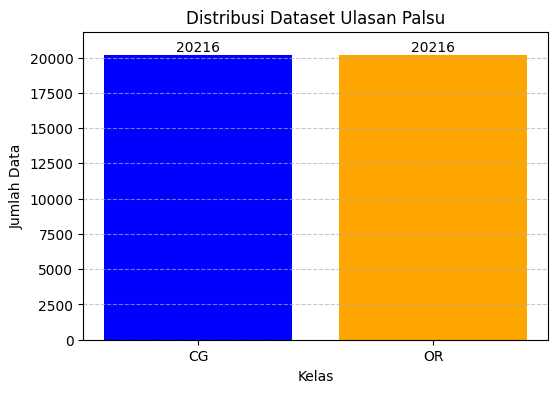

In [12]:
from collections import Counter
import matplotlib.pyplot as plt

train_counts = Counter(df['label'].astype(str))

label_mapping = {'0': 'OR', '1': 'CG'}
mapped_keys = [label_mapping[key] for key in train_counts.keys()]

plt.figure(figsize=(6, 4))
bars = plt.bar(mapped_keys, train_counts.values(), color=['blue', 'orange'])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Dataset Ulasan Palsu")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.margins(y=0.08)

plt.show()


## Data Splitting

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [14]:
label_counts = y_train.value_counts()

print("Jumlah Real Review Train (0):", label_counts[0])
print("Jumlah Fake Review Train (1):", label_counts[1])

Jumlah Real Review Train (0): 16172
Jumlah Fake Review Train (1): 16173


In [15]:
label_counts = y_test.value_counts()

print("Jumlah Real Review Test (0):", label_counts[0])
print("Jumlah Fake Review Test (1):", label_counts[1])

Jumlah Real Review Test (0): 4044
Jumlah Fake Review Test (1): 4043


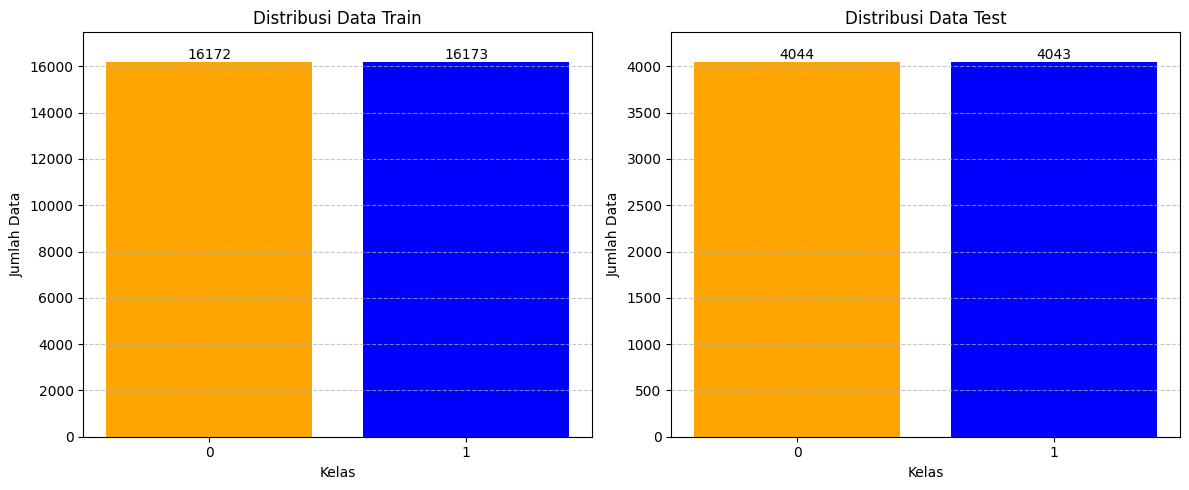

In [16]:
train_counts = Counter(y_train)
test_counts = Counter(y_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

bars_train = axes[0].bar(train_counts.keys(), train_counts.values(), color=['blue', 'orange'])
axes[0].set_title('Distribusi Data Train')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['0', '1'])
axes[0].set_xlabel('Kelas')
axes[0].set_ylabel('Jumlah Data')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].margins(y=0.08)

for bar in bars_train:
    height = bar.get_height()
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

bars_test = axes[1].bar(test_counts.keys(), test_counts.values(), color=['blue', 'orange'])
axes[1].set_title('Distribusi Data Test')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])
axes[1].set_xlabel('Kelas')
axes[1].set_ylabel('Jumlah Data')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].margins(y=0.08)

for bar in bars_test:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

## TF-IDF

In [17]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=30, max_df=0.90, strip_accents='unicode', sublinear_tf=True)
X_train_tfidf = vectorizer.fit_transform(X_train['cleaned_text'])
X_test_tfidf = vectorizer.transform(X_test['cleaned_text'])

In [18]:
print("Jumlah fitur yang diekstrak:", len(vectorizer.vocabulary_))

Jumlah fitur yang diekstrak: 10256


In [19]:
df_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
df_test_tfidf = pd.DataFrame(X_test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

print("Data hasil ekstraksi (train):\n", df_train_tfidf.head())
print("Data hasil ekstraksi (test):\n", df_test_tfidf.head())

Data hasil ekstraksi (train):
     aa  ability  ability to  able  able to  about  about an  about and  \
0  0.0      0.0         0.0   0.0      0.0    0.0       0.0        0.0   
1  0.0      0.0         0.0   0.0      0.0    0.0       0.0        0.0   
2  0.0      0.0         0.0   0.0      0.0    0.0       0.0        0.0   
3  0.0      0.0         0.0   0.0      0.0    0.0       0.0        0.0   
4  0.0      0.0         0.0   0.0      0.0    0.0       0.0        0.0   

   about buying  about getting  ...  youtube  youve   yr  yr old  zero  zip  \
0           0.0            0.0  ...      0.0    0.0  0.0     0.0   0.0  0.0   
1           0.0            0.0  ...      0.0    0.0  0.0     0.0   0.0  0.0   
2           0.0            0.0  ...      0.0    0.0  0.0     0.0   0.0  0.0   
3           0.0            0.0  ...      0.0    0.0  0.0     0.0   0.0  0.0   
4           0.0            0.0  ...      0.0    0.0  0.0     0.0   0.0  0.0   

   zipper  zipper is  zippers  zoom  
0     0.0  

In [20]:
print(df_train_tfidf.iloc[[0, 1, 2, 3, -1], [-1]])
print(df_train_tfidf.iloc[[-1], list(range(6)) + [-1]])

       zoom
0       0.0
1       0.0
2       0.0
3       0.0
32344   0.0
        aa  ability  ability to  able  able to  about  zoom
32344  0.0      0.0         0.0   0.0      0.0    0.0   0.0


In [21]:
print(df_test_tfidf.iloc[[0, 1, 2, 3, -1], [-1]])
print(df_test_tfidf.iloc[[-1], list(range(6)) + [-1]])

      zoom
0      0.0
1      0.0
2      0.0
3      0.0
8086   0.0
       aa  ability  ability to  able  able to  about  zoom
8086  0.0      0.0         0.0   0.0      0.0    0.0   0.0


## Unoptimized

In [22]:
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train)
dtest = xgb.DMatrix(X_test_tfidf, label=y_test)

In [23]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

In [24]:
rf_model = RandomForestClassifier(random_state=42)
svm_model = SVC(random_state=42)
nb_model = MultinomialNB()

In [25]:
rf_model.fit(X_train_tfidf, y_train)
svm_model.fit(X_train_tfidf, y_train)
nb_model.fit(X_train_tfidf, y_train)
xgb_model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, 'eval')], early_stopping_rounds=10, verbose_eval=False)

In [26]:
rf_y_pred = rf_model.predict(X_test_tfidf)
svm_y_pred = svm_model.predict(X_test_tfidf)
nb_y_pred = nb_model.predict(X_test_tfidf)
xgb_y_pred_prob = xgb_model.predict(dtest)
xgb_y_pred = (xgb_y_pred_prob > 0.5).astype(int)

RF

In [27]:
accuracy = accuracy_score(y_test, rf_y_pred)
print(f'Akurasi: {accuracy:.4f}')

precision_cg = precision_score(y_test, rf_y_pred)
print(f'Presisi (Fake Review): {precision_cg:.4f}')

recall_cg = recall_score(y_test, rf_y_pred)
print(f'Recall (Fake Review): {recall_cg:.4f}')

f1_cg = f1_score(y_test, rf_y_pred)
print(f'F1-Score (Fake Review): {f1_cg:.4f}')

Akurasi: 0.9038
Presisi (Fake Review): 0.9306
Recall (Fake Review): 0.8726
F1-Score (Fake Review): 0.9007


SVM

In [28]:
accuracy = accuracy_score(y_test, svm_y_pred)
print(f'Akurasi: {accuracy:.4f}')

precision_cg = precision_score(y_test, svm_y_pred)
print(f'Presisi (Fake Review): {precision_cg:.4f}')

recall_cg = recall_score(y_test, svm_y_pred)
print(f'Recall (Fake Review): {recall_cg:.4f}')

f1_cg = f1_score(y_test, svm_y_pred)
print(f'F1-Score (Fake Review): {f1_cg:.4f}')

Akurasi: 0.9504
Presisi (Fake Review): 0.9612
Recall (Fake Review): 0.9387
F1-Score (Fake Review): 0.9498


NB

In [29]:
accuracy = accuracy_score(y_test, nb_y_pred)
print(f'Akurasi: {accuracy:.4f}')

precision_cg = precision_score(y_test, nb_y_pred)
print(f'Presisi (Fake Review): {precision_cg:.4f}')

recall_cg = recall_score(y_test, nb_y_pred)
print(f'Recall (Fake Review): {recall_cg:.4f}')

f1_cg = f1_score(y_test, nb_y_pred)
print(f'F1-Score (Fake Review): {f1_cg:.4f}')

Akurasi: 0.9026
Presisi (Fake Review): 0.8974
Recall (Fake Review): 0.9090
F1-Score (Fake Review): 0.9032


XGB

In [30]:
accuracy = accuracy_score(y_test, xgb_y_pred)
print(f'Akurasi: {accuracy:.4f}')

precision_cg = precision_score(y_test, xgb_y_pred)
print(f'Presisi (Fake Review): {precision_cg:.4f}')

recall_cg = recall_score(y_test, xgb_y_pred)
print(f'Recall (Fake Review): {recall_cg:.4f}')

f1_cg = f1_score(y_test, xgb_y_pred)
print(f'F1-Score (Fake Review): {f1_cg:.4f}')

Akurasi: 0.9028
Presisi (Fake Review): 0.9183
Recall (Fake Review): 0.8842
F1-Score (Fake Review): 0.9010


## Optimized

In [31]:
rf_model2 = joblib.load('/kaggle/input/fake-review-model/scikitlearn/default/1/rf.pkl')
svm_model2 = joblib.load('/kaggle/input/fake-review-model/scikitlearn/default/1/svm.pkl')
nb_model2 = joblib.load('/kaggle/input/fake-review-model/scikitlearn/default/1/nb.pkl')
xgb_model2 = joblib.load('/kaggle/input/fake-review-model/scikitlearn/default/1/xgb.pkl')

In [32]:
rf_y_pred2 = rf_model2.predict(X_test_tfidf)
svm_y_pred2 = svm_model2.predict(X_test_tfidf)
nb_y_pred2 = nb_model2.predict(X_test_tfidf)
xgb_y_pred_prob2 = xgb_model.predict(dtest)
xgb_y_pred2 = (xgb_y_pred_prob2 > 0.5).astype(int)

RF

In [33]:
accuracy = accuracy_score(y_test, rf_y_pred2)
print(f'Akurasi: {accuracy:.4f}')

precision_cg = precision_score(y_test, rf_y_pred2)
print(f'Presisi (Fake Review): {precision_cg:.4f}')

recall_cg = recall_score(y_test, rf_y_pred2)
print(f'Recall (Fake Review): {recall_cg:.4f}')

f1_cg = f1_score(y_test, rf_y_pred2)
print(f'F1-Score (Fake Review): {f1_cg:.4f}')

Akurasi: 0.9127
Presisi (Fake Review): 0.9376
Recall (Fake Review): 0.8842
F1-Score (Fake Review): 0.9101


SVM

In [34]:
accuracy = accuracy_score(y_test, svm_y_pred2)
print(f'Akurasi: {accuracy:.4f}')

precision_cg = precision_score(y_test, svm_y_pred2)
print(f'Presisi (Fake Review): {precision_cg:.4f}')

recall_cg = recall_score(y_test, svm_y_pred2)
print(f'Recall (Fake Review): {recall_cg:.4f}')

f1_cg = f1_score(y_test, svm_y_pred2)
print(f'F1-Score (Fake Review): {f1_cg:.4f}')

Akurasi: 0.9513
Presisi (Fake Review): 0.9602
Recall (Fake Review): 0.9416
F1-Score (Fake Review): 0.9508


NB

In [35]:
accuracy = accuracy_score(y_test, nb_y_pred2)
print(f'Akurasi: {accuracy:.4f}')

precision_cg = precision_score(y_test, nb_y_pred2)
print(f'Presisi (Fake Review): {precision_cg:.4f}')

recall_cg = recall_score(y_test, nb_y_pred2)
print(f'Recall (Fake Review): {recall_cg:.4f}')

f1_cg = f1_score(y_test, nb_y_pred2)
print(f'F1-Score (Fake Review): {f1_cg:.4f}')

Akurasi: 0.9049
Presisi (Fake Review): 0.9054
Recall (Fake Review): 0.9043
F1-Score (Fake Review): 0.9048


XGB

In [36]:
accuracy = accuracy_score(y_test, xgb_y_pred2)
print(f'Akurasi: {accuracy:.4f}')

precision_cg = precision_score(y_test, xgb_y_pred2)
print(f'Presisi (Fake Review): {precision_cg:.4f}')

recall_cg = recall_score(y_test, xgb_y_pred2)
print(f'Recall (Fake Review): {recall_cg:.4f}')

f1_cg = f1_score(y_test, xgb_y_pred2)
print(f'F1-Score (Fake Review): {f1_cg:.4f}')

Akurasi: 0.9028
Presisi (Fake Review): 0.9183
Recall (Fake Review): 0.8842
F1-Score (Fake Review): 0.9010


## Comparison

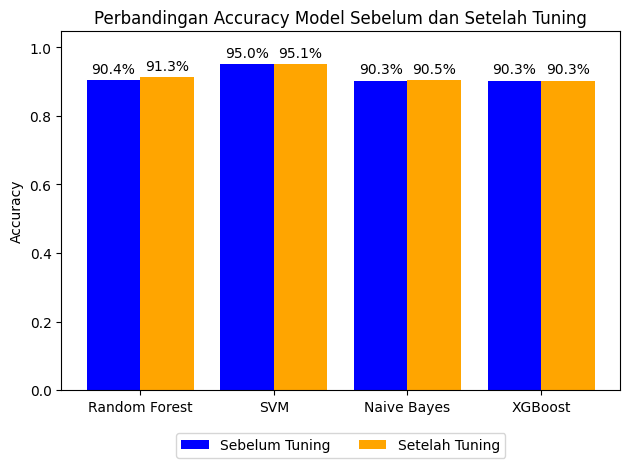

In [37]:
models = ['Random Forest', 'SVM', 'Naive Bayes', 'XGBoost']
accuracy_before = [accuracy_score(y_test, rf_y_pred), accuracy_score(y_test, svm_y_pred), accuracy_score(y_test, nb_y_pred), accuracy_score(y_test, xgb_y_pred)]
accuracy_after = [accuracy_score(y_test, rf_y_pred2), accuracy_score(y_test, svm_y_pred2), accuracy_score(y_test, nb_y_pred2), accuracy_score(y_test, xgb_y_pred2)]

x = np.arange(len(models))
width = 0.40

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, accuracy_before, width, label='Sebelum Tuning', color='blue')
bars2 = ax.bar(x + width/2, accuracy_after, width, label='Setelah Tuning', color='orange')

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height*100:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height*100:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_ylabel('Accuracy')
ax.set_title('Perbandingan Accuracy Model Sebelum dan Setelah Tuning')
ax.set_xticks(x)
ax.margins(y=0.1)
ax.set_xticklabels(models)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2)

plt.tight_layout()
plt.show()
